## TODO 
- [ ] check the galaxy counts expected for LSST 
- [x] find the equations for the effect of magnification on the redshift distriution
- [ ] include the redshift information in the model
- [ ] check the galaxy counts expected for DESI
- [ ] check the problem of radius limit in modelling

# Bibio 
- https://arxiv.org/pdf/astro-ph/9912508.pdf
- https://iopscience.iop.org/article/10.1088/0004-637X/772/1/65/pdf
- https://arxiv.org/pdf/astro-ph/9511150.pdf
- https://arxiv.org/pdf/astro-ph/9406052.pdf
- faint end slope https://iopscience.iop.org/article/10.1086/505455/pdf, https://www.aanda.org/articles/aa/pdf/2003/13/aa3018.pdf

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import sys
sys.path.append('./support')
import clmm
import clmm.modeling as mod
import scipy.integrate as integrate

In [10]:
from astropy.cosmology import FlatLambdaCDM
astropy_cosmology_object = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)
cosmo_ccl = mod.cclify_astropy_cosmo(astropy_cosmology_object)

In [11]:
density_profile_parametrization = 'nfw'
mass_Delta = 200
cluster_mass = 1.81e14
cluster_concentration = 4
z_cl = 0.2
z_source = 2

In [12]:
r3d = np.logspace(-2, 2, 100)

In [13]:
rho = mod.get_3d_density(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, 
                       z_cl=z_cl, cosmo=cosmo_ccl)

Sigma = mod.predict_surface_density(r3d, cluster_mass, cluster_concentration, z_cl, cosmo=cosmo_ccl, 
                                  delta_mdef=mass_Delta, 
                                  halo_profile_model=density_profile_parametrization)

DeltaSigma = mod.predict_excess_surface_density(r3d, cluster_mass, cluster_concentration, z_cl, cosmo=cosmo_ccl, 
                                              delta_mdef=mass_Delta, 
                                              halo_profile_model=density_profile_parametrization)

Sigmac = mod.get_critical_surface_density(cosmo_ccl, z_cluster=z_cl, z_source=z_source)

gammat = mod.predict_tangential_shear(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, z_cluster=z_cl, 
                                    z_source=z_source, cosmo=cosmo_ccl, delta_mdef=mass_Delta, 
                                    halo_profile_model=density_profile_parametrization, 
                                    z_src_model='single_plane')

kappa = mod.predict_convergence(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, 
                               z_cluster=z_cl, z_source=z_source,
                               cosmo=cosmo_ccl, delta_mdef=mass_Delta, 
                               halo_profile_model=density_profile_parametrization, 
                               z_src_model='single_plane')

gt = mod.predict_reduced_tangential_shear(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, 
                                        z_cluster=z_cl, z_source=z_source, cosmo=cosmo_ccl, 
                                        delta_mdef=mass_Delta, 
                                        halo_profile_model=density_profile_parametrization, 
                                        z_src_model='single_plane')
        

In [14]:
def plot_profile(r, profile_vals, profile_label='rho', label=None):
    plt.loglog(r, profile_vals, label=label)
    plt.xlabel('r [Mpc]', fontsize='xx-large')
    plt.ylabel(profile_label, fontsize='xx-large')

## Magnification definition

In [15]:
#without limits

def mu(kappa,gamma):
    mu = 1 / ((1-kappa)**2-abs(gamma)**2)
    return mu

In [16]:
#in the WL limit

def mu_wl(kappa): 
    "magnification with WL approximation"
    mu_wl = 1 + 2*kappa
    return mu_wl

In [17]:
#arbitrary Wl/SL limit : when the convergence is k>0.1
WL_limit_radius= r3d[kappa<0.1][0]

In [18]:
magnification = mu(kappa,gammat)
magnification_wl = mu_wl(kappa)

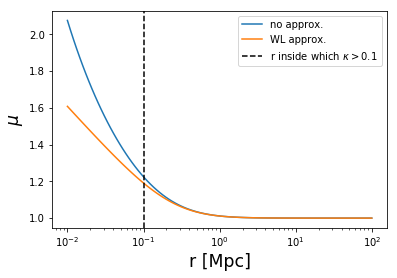

In [19]:
plot_profile(r3d,magnification, '$\mu$', "no approx.")
plot_profile(r3d,magnification_wl, '$\mu$', "WL approx.")
plt.axvline(WL_limit_radius,color='black', linestyle='dashed', label="r inside which $\\kappa>0.1$")
plt.legend()
plt.yscale('linear')

## Magnification bias definition

In [20]:
#magnification bias : number of lensed source over the number of unlensed source
#beta = slope of the power law luminosity function around the limiting flux of the survey, with N ~ AS^(-beta)

def mu_bias(mu,beta):
    mu_bias = mu**(beta-1)
    return mu_bias

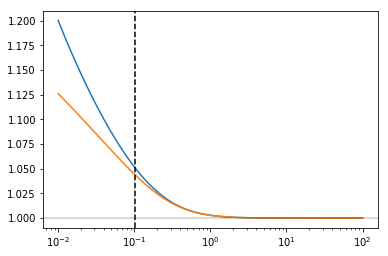

In [21]:
#For early type galaxies

alpha_ET = 0.50
beta_ET = alpha_ET * 2.5

plt.plot(r3d, mu_bias(magnification,beta_ET))
plt.plot(r3d, mu_bias(magnification_wl,beta_ET))
plt.xscale('log')
plt.axhline(1,color='black',alpha=0.2)
plt.axvline(WL_limit_radius,color='black', linestyle='dashed', label="r inside which $\\kappa>0.1$")

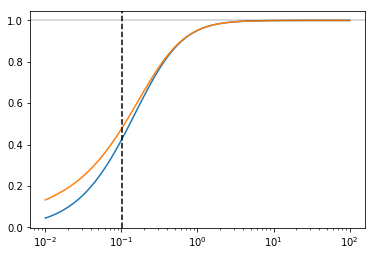

In [22]:
#For late type galaxies

alpha_LT = -1.30
beta_LT = alpha_LT * 2.5

plt.plot(r3d, mu_bias(magnification,beta_LT))
plt.plot(r3d, mu_bias(magnification_wl,beta_LT))
plt.xscale('log')
plt.axhline(1,color='black',alpha=0.2)
plt.axvline(WL_limit_radius,color='black', linestyle='dashed', label="r inside which $\\kappa>0.1$")

## Magnification bias in redshift distribution

In [23]:
#definition of a redshift distribution following Chang et al. 2013 arXiv:1305.0793

def pzfxn(z):
    """Redshift distribution function"""
    alpha, beta, z0 = 1.24, 1.01, 0.51
    return (z**alpha)*np.exp(-(z/z0)**beta)

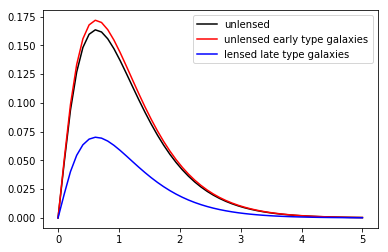

In [24]:
z = np.linspace(0,5)
plt.plot(z, pzfxn(z),'k', label ='unlensed')
plt.plot(z, pzfxn(z) * mu_bias(magnification[np.argwhere(r3d>0.1)][0],beta_ET),'r', label ='unlensed early type galaxies')
plt.plot(z, pzfxn(z) * mu_bias(magnification[np.argwhere(r3d>0.1)][0],beta_LT),'b', label ='lensed late type galaxies')
plt.legend()

In [28]:
def beta_z(z, beta_0,beta_1):
    beta = beta_0 + beta_1 * (1+z)
    return beta


In [35]:
def mu_bias(z, mu, beta_0, beta_1):
    mu_bias = mu**(beta_z(z,beta_0, beta_1) -1)
    return mu_bias

In [41]:
beta_0, beta_1 = 0.9, 0.1
mu_bias(z, magnification[np.argwhere(r3d>0.1)][0], beta_0, beta_1)

array([1.        , 1.00203386, 1.00407185, 1.00611399, 1.00816029,
       1.01021074, 1.01226537, 1.01432417, 1.01638716, 1.01845435,
       1.02052574, 1.02260135, 1.02468117, 1.02676523, 1.02885352,
       1.03094606, 1.03304286, 1.03514392, 1.03724926, 1.03935888,
       1.04147279, 1.043591  , 1.04571351, 1.04784034, 1.0499715 ,
       1.052107  , 1.05424683, 1.05639102, 1.05853957, 1.06069249,
       1.06284979, 1.06501147, 1.06717756, 1.06934804, 1.07152295,
       1.07370227, 1.07588603, 1.07807423, 1.08026688, 1.08246399,
       1.08466557, 1.08687162, 1.08908216, 1.0912972 , 1.09351675,
       1.09574081, 1.09796939, 1.1002025 , 1.10244016, 1.10468236])

In [42]:
#mean redshift of the distribution

def z_mean(func, a, b):
    num = integrate.quad(lambda x: func(x)*x, a, b)
    den = integrate.quad(lambda x: func(x), a, b)
    return num[0]/den[0]

In [43]:
z_mean(pzfxn, 0, np.inf)

1.1199061848352572

In [46]:
def fct(z):
    return pzfxn(z)*mu_bias(z, magnification[np.argwhere(r3d>0.1)][0], beta_0, beta_1)

In [48]:
z_mean(fct, 0, np.inf)

1.1310539254100362